In [1]:
import os
import pickle
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from matplotlib.lines import Line2D
from torch.backends.cudnn import allow_tf32

In [2]:
paper_plots_path = Path("/Users/jorisg/Desktop/upper_limb/paper_figures_revision")

participants = [
    "P_149",
    "P_238",
    "P_407",
    "P_426",
    "P_577",
    "P_668",
    "P_711",
    "P_950",
    "P7_453",
    "P6_820",
]
targets = [
    "indexAng",
    "midAng",
    "ringAng",
    "pinkyAng",
    "thumbInPlaneAng",
    "thumbOutPlaneAng",
    "wristFlex",
]
recordings = [
    "thumbFlEx",
    "thumbAbAd",
    "indexFlEx",
    "mrpFlEx",
    "fingersFlEx",
    "wristFlEx",
    "handOpCl",
    "pinchOpCl",
    "pointOpCl",
]
test_recordings = ["keyOpCl", "wristFlHandCl", "indexFlDigitsEx"]

channel_names = [
    "FPL",
    "EPL",
    "FDSr",
    "EIP",
    "FDSh",
    "EDC",
    "FCU",
    "ECU",
]

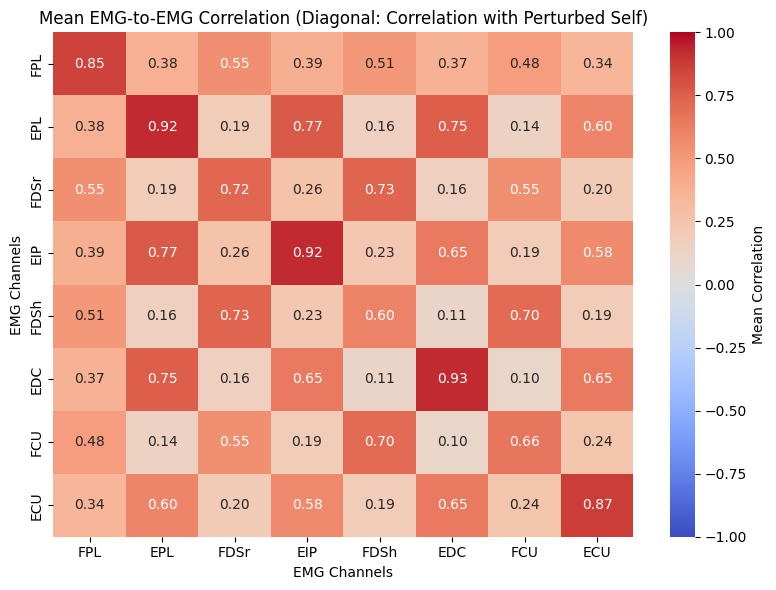

In [5]:
## creating and plotting the correlation matrix
expected_int_features = [0, 1, 2, 4, 10, 11, 12, 13]
all_participant_corrs = []
for participant in participants:
    all_corrs = []
    for recording in recordings + test_recordings:
        data_dir = Path(f"data/{participant}/recordings/{recording}/experiments/1")
        perturber_path = Path(f"data/{participant}/online_trials/perturb/perturber.npy")
        config_path = Path(f"data/{participant}/configs/modular.yaml")
        if not data_dir.exists():
            print(
                f"Skipping {participant} - {recording}: Data directory does not exist."
            )
            continue
        if not perturber_path.exists():
            print(
                f"Skipping {participant} - {recording}: Perturber file does not exist."
            )
            continue
        if not config_path.exists():
            print(f"Skipping {participant} - {recording}: Config file does not exist.")
            continue
        perturber = np.load(perturber_path)
        with open(config_path, "r") as f:
            config = yaml.safe_load(f)
        features = config["parameters"]["features"]["value"]
        try:
            emg = np.load(data_dir / "cropped_emg.npy")
        except:
            print(f"Skipping {participant} - {recording}: EMG data not found.")
            continue
        int_features = [int(feature[1]) for feature in features]
        # compare to expected_int_features
        if int_features != expected_int_features:
            print(
                f"Skipping {participant} - {recording}: Int features do not match expected."
            )
        emg = emg[:, int_features]
        perturbed_emg = (perturber @ emg.T).T

        emg_df = pd.DataFrame(emg, columns=channel_names)
        emg_corr = pd.DataFrame(
            np.corrcoef(emg.T), columns=emg_df.columns, index=emg_df.columns
        )
        self_corr = [
            np.corrcoef(emg[:, i], perturbed_emg[:, i])[0, 1]
            for i in range(emg.shape[1])
        ]
        for i in range(emg.shape[1]):
            emg_corr.iloc[i, i] = self_corr[i]
        # emg_corr.columns = [f"emg_{int_features[i]}" for i in range(emg.shape[1])]
        # emg_corr.index = [f"emg_{int_features[i]}" for i in range(emg.shape[1])]
        all_corrs.append(emg_corr.values)
    if all_corrs:
        # mean_corr = np.mean(all_corrs, axis=0)
        all_participant_corrs.append(all_corrs)

# Compute grand mean and std across participants
mean_per_participant_corrs = [
    np.mean(np.array(participant_corrs), axis=0)
    for participant_corrs in all_participant_corrs
]
mean_per_participant_corrs = np.array(mean_per_participant_corrs)
grand_mean = np.mean(mean_per_participant_corrs, axis=0)
grand_std = np.std(mean_per_participant_corrs, axis=0)


# Plot mean
plt.figure(figsize=(8, 6))
sns.heatmap(
    grand_mean,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=emg_corr.columns,
    yticklabels=emg_corr.columns,
    cbar_kws={"label": "Mean Correlation"},
)
plt.title("Mean EMG-to-EMG Correlation (Diagonal: Correlation with Perturbed Self)")
plt.xlabel("EMG Channels")
plt.ylabel("EMG Channels")
plt.tight_layout()
# save with 600 dpi
plt.savefig(paper_plots_path / "emg_correlation_heatmap.pdf", dpi=600)
plt.show()
# save the grand mean as numpy array
np.save(paper_plots_path / "grand_mean_emg_correlation.npy", grand_mean)

In [ ]:
(
    grand_mean.diagonal().min().round(3),
    grand_mean.diagonal().max().round(3),
    grand_mean.diagonal().mean().round(3),
)

(0.605, 0.925, 0.81)

In [ ]:
# ranking the perturbed autocorrelation vs other channels for all participants and movements


str_channel_mapping = {  # switching channels pairwise with the closest neighbor
    "FPL": "FDSr",
    "EPL": "EIP",
    "FDSr": "FPL",
    "EIP": "EPL",
    "FDSh": "FCU",
    "EDC": "ECU",
    "FCU": "FDSh",
    "ECU": "EDC",
}

closest_channels = []
for channel_name in channel_names:
    closest_channels.append(channel_names.index(str_channel_mapping[channel_name]))

all_ranks = []
all_autocorrs = []
all_max_corrs = []
all_second_to_max_corrs = []
all_pairwise_switched_corrs = []
for participant_correlation in all_participant_corrs:
    for movement_correlation in participant_correlation:
        perturbed_self_corr = np.diag(participant_correlation)
        corr = np.copy(participant_correlation)
        np.fill_diagonal(corr, 0)
        ranks = np.zeros(corr.shape[0])
        for i in range(corr.shape[0]):
            self_corr = perturbed_self_corr[i]
            rank = np.sum(corr[i] > self_corr) + 1  # +1 for 1-based ranking
            ranks[i] = rank
        all_ranks.append(ranks)
        all_autocorrs.append(perturbed_self_corr)
        all_max_corrs.append(np.max(corr, axis=1))
        all_second_to_max_corrs.append(np.sort(corr, axis=1)[:, -2])
        all_pairwise_switched_corrs.append(
            [corr[i, closest_channels[i]] for i in range(corr.shape[0])]
        )


# Compute grand mean and std of ranks across participants
all_ranks = np.array(all_ranks)


# Print the average autocorrelation and max correlation
print(f"Average Autocorrelation (Perturbed Self-Correlation): {np.mean(all_autocorrs)}")
print(f"Average Correlation to closest channel: {np.mean(all_pairwise_switched_corrs)}")
print(f"Average Max Correlation (Other Channels): {np.mean(all_max_corrs)}")
print(
    f"Average Second to Max Correlation (Other Channels): {np.mean(all_second_to_max_corrs)}"
)
print(
    f"Average similarity rank of the perturbed self-correlation: {np.mean(all_ranks)}"
)
# plot the histogram of ranks
plt.figure(figsize=(8, 6))
plt.hist(all_ranks.flatten(), bins=np.arange(1, 10) - 0.5, density=True, alpha=0.7)
plt.xticks(np.arange(1, 9))
plt.xlabel("Rank of Perturbed Self-Correlation")
plt.ylabel("Density")
plt.title("Distribution of Ranks of Perturbed Self-Correlation Across Participants")
# plt.axvline(np.mean(grand_mean_ranks), color='red', linestyle='--', label='Mean Rank')
plt.legend()
plt.tight_layout()
plt.show()
# print the percentages per rank
for rank in range(1, 9):
    percentage = np.sum(all_ranks.flatten() == rank) / len(all_ranks.flatten()) * 100
    print(f"Percentage of channels with rank {rank}: {percentage}%")